# CS 480/680 Project: Predicting 6 Vital Plant Traits

This notebook was inspired by [this notebook](https://www.kaggle.com/code/korotas/9th-place-planttraits2024-dinov2-catboost).

### Setup Environment

In [1]:
! pip --quiet install fastai xformers 'numpy<2' pandas matplotlib tqdm 'torchvision<0.16.2' scikit-learn catboost ipywidgets

In [2]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from sklearn.metrics import r2_score
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 6
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

if os.getenv('KAGGLE_KERNEL_RUN_TYPE') is not None:
    DATASET_DIR = '/kaggle/input/cs-480-2024-spring/data'
    IMG_FEATURES_DIR = '/kaggle/input/cs480-sping-2024-image-features3'
    print(f"Running on Kaggle, dataset dir: {DATASET_DIR}")
else:
    DATASET_DIR = 'data'
    IMG_FEATURES_DIR = 'img_features'

RECOMPUTE_IMAGE_FEATURES = False
TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Running on Kaggle, dataset dir: /kaggle/input/cs-480-2024-spring/data
Using device: cuda:0


### Preprocess Ancillary Data

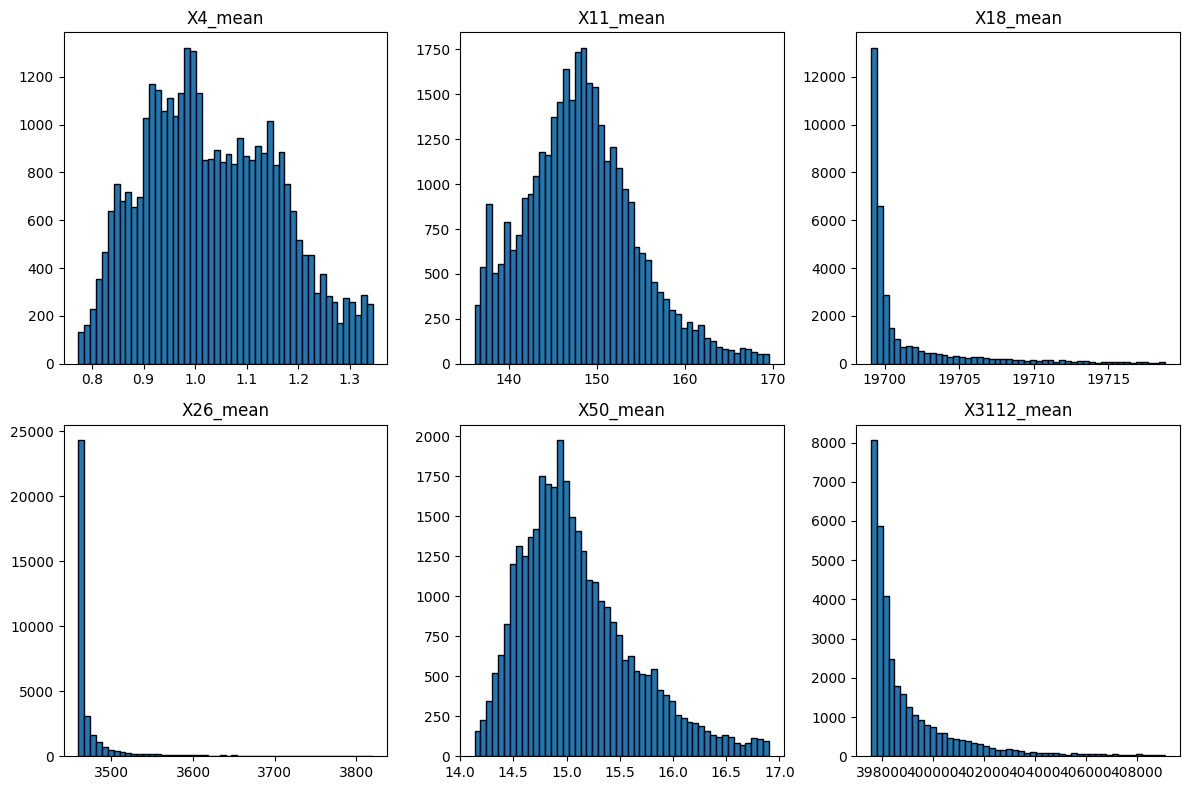

In [3]:
def plot_targets(data):
    _, axs = plt.subplots(2, 3, figsize=(12, 8))
    axs = axs.flatten()
    for i, col in enumerate(TARGET_COLUMNS):
        axs[i].hist(data[:, i], bins=50, edgecolor='black')
        axs[i].set_title(col)
    plt.tight_layout()
    plt.show()


df_train = pd.read_csv(f'{DATASET_DIR}/train.csv')
df_test = pd.read_csv(f'{DATASET_DIR}/test.csv')

val_size = 4096
train_data, val_data = train_test_split(df_train, test_size=val_size, random_state=SEED)

# Remove outliers
for col in TARGET_COLUMNS:
    upper_quantile = train_data[col].quantile(0.99)
    under_quantile = train_data[col].quantile(0.01)
    train_data = train_data[(train_data[col] < upper_quantile)]
    train_data = train_data[(train_data[col] > under_quantile)]

train_ids = train_data['id'].values
val_ids = val_data['id'].values
all_train_ids = df_train['id'].values
test_ids = df_test['id'].values

raw_train_X = train_data.drop(['id'] + TARGET_COLUMNS, axis=1).values
raw_val_X = val_data.drop(['id'] + TARGET_COLUMNS, axis=1).values
raw_test_X = df_test.drop(['id'], axis=1).values

train_y = train_data[TARGET_COLUMNS].values
val_y = val_data[TARGET_COLUMNS].values

data_norm = StandardScaler()
train_X = data_norm.fit_transform(raw_train_X)
val_X = data_norm.transform(raw_val_X)
test_X = data_norm.transform(raw_test_X)

plot_targets(train_y)

### Extract Features from Images

In [4]:
def extract_features(image_dir, ids, model, transform, batch_size=64):
    image_features = []
    model.eval()

    with torch.no_grad():
        for i in tqdm(range(0, len(ids), batch_size), desc=f'Extracting features for images in {image_dir}', leave=False):
            paths = [f'{image_dir}/{id}.jpeg' for id in ids[i:i + batch_size]]
            image_tensor = torch.stack([transform(Image.open(path)) for path in paths]).to(DEVICE)
            curr_image_feature = model(image_tensor)
            cur_batch_size = curr_image_feature.size(0)
            curr_image_feature = curr_image_feature.view(cur_batch_size, -1)
            image_features.extend(curr_image_feature.cpu().numpy())

    return np.array(image_features)


batch_size = 128
suffix = 'image_features_dinov2_vitg14_reg'
if RECOMPUTE_IMAGE_FEATURES:
    os.makedirs('img_features', exist_ok=True)

    img_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg').to(DEVICE)
    transform = transforms.Compose([
        transforms.Resize(224, interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.446, 0.45, 0.336],
                             std=[0.183, 0.179, 0.178]),
    ])

    all_train_img_features = extract_features(
        f'{DATASET_DIR}/train_images', all_train_ids, img_model, transform, batch_size)
    np.save(f'img_features/all_train_{suffix}', all_train_img_features)

    test_img_features = extract_features(
        f'{DATASET_DIR}/test_images', test_ids, img_model, transform, batch_size)
    np.save(f'img_features/test_{suffix}', test_img_features)

    print("Image features extracted")
else:
    all_train_img_features = np.load(f'{IMG_FEATURES_DIR}/all_train_{suffix}.npy')
    test_img_features = np.load(f'{IMG_FEATURES_DIR}/test_{suffix}.npy')

    print(f"Image features loaded from {IMG_FEATURES_DIR}")

print(f"Train image features shape: {all_train_img_features.shape}")
print(f"Test image features shape: {test_img_features.shape}")

Image features loaded from /kaggle/input/cs480-sping-2024-image-features3
Train image features shape: (43363, 1536)
Test image features shape: (6391, 1536)


### Combine Features

In [5]:
# Splitting image features
all_train_idto_img_features_map = {id: feature
                                   for id, feature in zip(all_train_ids, all_train_img_features)}
train_img_features = np.array([all_train_idto_img_features_map[id] for id in train_ids])
val_img_features = np.array([all_train_idto_img_features_map[id] for id in val_ids])

# Combining image and tabular features
first_n_poly_feats = 1536
polynomial = PolynomialFeatures(2, interaction_only=True)

train_features_mask_all = np.concatenate(
    (polynomial.fit_transform(train_X)[:, :first_n_poly_feats], train_img_features),
    axis=1
)
print(f'Train features shape: {train_features_mask_all.shape}')
val_features_mask_all = np.concatenate(
    (polynomial.transform(val_X)[:, :first_n_poly_feats], val_img_features),
    axis=1
)
print(f'Validation features shape: {val_features_mask_all.shape}')
test_features_all = np.concatenate(
    (polynomial.transform(test_X)[:, :first_n_poly_feats], test_img_features),
    axis=1
)
print(f'Test features shape: {test_features_all.shape}')

train_features = pd.DataFrame(train_features_mask_all)
train_features['emb'] = list(train_img_features)

val_features = pd.DataFrame(val_features_mask_all)
val_features['emb'] = list(val_img_features)

test_features = pd.DataFrame(test_features_all)
test_features['emb'] = list(test_img_features)

Train features shape: (34764, 3072)
Validation features shape: (4096, 3072)
Test features shape: (6391, 3072)


### Training Models

In [6]:
models = {}
scores = []

for i, col in tqdm(enumerate(TARGET_COLUMNS), desc='Training Models', leave=False):
    curr_train_y = train_y[:, i]
    curr_val_y = val_y[:, i]

    train_pool = Pool(train_features, curr_train_y, embedding_features=['emb'])
    val_pool = Pool(val_features, curr_val_y, embedding_features=['emb'])

    model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.085,
        loss_function='RMSE',
        verbose=0,
        random_state=SEED,
        task_type="GPU",
        devices='0'
    )

    model.fit(train_pool)
    models[col] = model

    curr_val_y_pred = model.predict(val_pool)

    r2_col = r2_score(curr_val_y, curr_val_y_pred)
    scores.append(r2_col)
    print(f'Target: {col}, R2: {r2_col:.3f}')

mean_r2 = np.mean(scores)
print(f'Mean R2: {mean_r2:.3f}')

Training Models: 0it [00:00, ?it/s]

Target: X4_mean, R2: 0.513
Target: X11_mean, R2: 0.473
Target: X18_mean, R2: 0.628
Target: X26_mean, R2: 0.272
Target: X50_mean, R2: 0.366
Target: X3112_mean, R2: 0.463
Mean R2: 0.452


### Prediction

In [7]:
submission = pd.DataFrame({'id': test_ids})
submission[TARGET_COLUMNS] = 0
submission.columns = submission.columns.str.replace('_mean', '')
for i, col in enumerate(TARGET_COLUMNS):
    test_pool = Pool(test_features, embedding_features=['emb'])
    col_pred = models[col].predict(test_pool)
    submission[col.replace('_mean', '')] = col_pred

submission.to_csv('submission.csv', index=False)
submission.head()

,id,X4,X11,X18,X26,X50,X3112
0,154220505,1.109406,145.965978,19706.819122,3490.544111,15.003079,399446.079213
1,195736552,0.990956,153.640750,19699.303607,3455.574984,14.976054,399110.252356
2,182701773,0.990715,147.036956,19699.178813,3460.393230,14.885571,397801.376549
3,27688500,0.990093,139.621185,19699.214450,3495.450705,16.162396,398170.099062
4,195825045,0.925819,153.254687,19699.452512,3459.140126,14.829239,398983.488103
